# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast

from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter

In [3]:
from ubs8k.datasetManager import DatasetManager
from ubs8k.datasets import Dataset

from DCT.util.utils import reset_seed, get_datetime
from DCT.util.model_loader import get_model_from_name
from DCT.util.dataset_loader import load_dataset
from DCT.util.checkpoint import CheckPoint
from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

# Arguments

In [4]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="cifar10", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="wideresnet28_2", type=str)
group_t.add_argument("--supervised_ratio", default=0.08, type=float)
group_t.add_argument("--batch_size", default=128, type=int)
group_t.add_argument("--nb_epoch", default=200, type=int)
group_t.add_argument("--learning_rate", default=0.1, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_u = parser.add_argument_group("UrbanSound8k parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4, 5, 6, 7, 8, 9], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[10], type=int)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [5]:
args

Namespace(batch_size=128, checkpoint_path='supervised', checkpoint_root='../model_save/', dataset='cifar10', dataset_root='../datasets', from_config='', learning_rate=0.1, model='wideresnet28_2', nb_epoch=200, resume=False, seed=1234, supervised_ratio=0.08, tensorboard_path='supervised', tensorboard_root='../tensorboard/', tensorboard_sufix='', train_folds=[1, 2, 3, 4, 5, 6, 7, 8, 9], val_folds=[10])

# initialisation

In [6]:
reset_seed(args.seed)


# Prepare the dataset

In [7]:
"""
we pre-processed the images using ZCA and augmented the dataset using horizontal flips and random translations. The translations
were drawn from [−2, 2] pixels,
"""
extra_train_transforms = [
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
]

manager, train_loader, val_loader = load_dataset(
    args.dataset,
    "supervised",
    
    extra_train_transform = extra_train_transforms,
    
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    verbose = 2
)

Files already downloaded and verified
Files already downloaded and verified


# Prep model

In [27]:
torch.cuda.empty_cache()


model_func = get_model_from_name(args.model)
model = model_func()
model = model.cuda()


In [28]:
from torchsummaryX import summary
input_tensor = torch.zeros((64, 3, 32, 32), dtype=torch.float)
input_tensor = input_tensor.cuda()

s = summary(model, input_tensor)


                                          Kernel Shape      Output Shape  \
Layer                                                                      
0_conv1                                  [3, 32, 3, 3]  [64, 32, 32, 32]   
1_bn1                                             [32]  [64, 32, 32, 32]   
2_relu                                               -  [64, 32, 32, 32]   
3_maxpool                                            -  [64, 32, 16, 16]   
4_layer1.0.Conv2d_conv1                 [32, 32, 3, 3]  [64, 32, 16, 16]   
5_layer1.0.BatchNorm2d_bn1                        [32]  [64, 32, 16, 16]   
6_layer1.0.ReLU_relu                                 -  [64, 32, 16, 16]   
7_layer1.0.Conv2d_conv2                 [32, 32, 3, 3]  [64, 32, 16, 16]   
8_layer1.0.BatchNorm2d_bn2                        [32]  [64, 32, 16, 16]   
9_layer1.0.ReLU_relu                                 -  [64, 32, 16, 16]   
10_layer1.1.Conv2d_conv1                [32, 32, 3, 3]  [64, 32, 16, 16]   
11_layer1.1.

## Prep training

In [29]:
nb_conv = 0

for layer in s.index.values:
    if "Conv" in layer:
        nb_conv += 1
print(nb_conv)

26


In [30]:
# create model
torch.cuda.empty_cache()

model = model_func()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# training parameters

In [31]:
# tensorboard
tensorboard_title = "%s_%s_%.1fS" % (get_datetime(), model_func.__name__, args.supervised_ratio)
checkpoint_title = "%s_%.1fS" % (model_func.__name__, args.supervised_ratio)
tensorboard = SummaryWriter(log_dir="%s/%s" % (tensorboard_path, tensorboard_title), comment=model_func.__name__)
print(os.path.join(tensorboard_path, tensorboard_title))

# losses
loss_ce = nn.CrossEntropyLoss(reduction="mean")

../tensorboard/cifar10/supervised/2020-08-27_11:16:39_wideresnet28_2_0.1S


## cifar10 optimizer

In [32]:
if args.dataset == "cifar10":
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
    
    def lr_lambda(e):
        if e < 60:
            return 1

        elif 60 <= e < 120:
            return 0.2

        elif 120 <= e < 160:
            return 0.04

        else:
            return 0.008
    


## ubs8k optimizer

In [33]:
if args.dataset == "ubs8k":
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    lr_lambda = lambda epoch: (1.0 + numpy.cos((epoch-1)*numpy.pi/args.nb_epoch)) * 0.5

In [34]:
lr_scheduler = LambdaLR(optimizer, lr_lambda)

# Checkpoint
checkpoint = CheckPoint(model, optimizer, mode="max", name="%s/%s.torch" % (checkpoint_path, checkpoint_title))

# Metrics
fscore_fn = FScore()
acc_fn = CategoricalAccuracy()
avg = ContinueAverage()

reset_metrics = lambda : [m.reset() for m in [fscore_fn, acc_fn, avg]]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

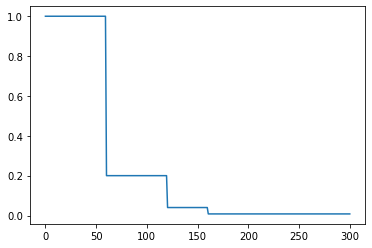

In [35]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 300, 300)
y = [lr_lambda(x_) for x_ in x]

plt.plot(x, y)


In [36]:
def maximum():
    def func(key, value):
        if key not in func.max:
            func.max[key] = value
        else:
            if func.max[key] < value:
                func.max[key] = value
        return func.max[key]

    func.max = dict()
    return func
maximum_fn = maximum()

## Can resume previous training

In [37]:
if args.resume:
    checkpoint.load_last()

In [38]:
args.resume

False

## training function

In [39]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"


header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} - {:<9.9} {:<12.12}| {:<9.9}- {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} - {:<9.9} {:<10.4f}| {:<9.4f}- {:<6.4f}"

header = header_form.format(
    "", "Epoch", "%", "Losses:", "ce", "metrics: ", "acc", "F1 ","Time"
)


train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

         Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  


In [40]:
def train(epoch):
    start_time = time.time()
    print("")

    reset_metrics()
    model.train()

    for i, (X, y) in enumerate(train_loader):        
        X = X.cuda()
        y = y.cuda()

        logits = model(X)        
        loss = loss_ce(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.set_grad_enabled(False):
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=10)

            acc = acc_fn(pred_arg, y).mean
            fscore = fscore_fn(pred, y_one_hot).mean
            avg_ce = avg(loss.item()).mean

            # logs
            print(train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / len(train_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("train/Lce", avg_ce, epoch)
    tensorboard.add_scalar("train/f1", fscore, epoch)
    tensorboard.add_scalar("train/acc", acc, epoch)

In [41]:
def val(epoch):
    start_time = time.time()
    print("")
    reset_metrics()
    model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(val_loader):
            X = X.cuda()
            y = y.cuda()

            logits = model(X)
            loss = loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=10)

            acc = acc_fn(pred_arg, y).mean
            fscore = fscore_fn(pred, y_one_hot).mean
            avg_ce = avg(loss.item()).mean

            # logs
            print(val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / len(val_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/Lce", avg_ce, epoch)
    tensorboard.add_scalar("val/f1", fscore, epoch)
    tensorboard.add_scalar("val/acc", acc, epoch)
    
    tensorboard.add_scalar("hyperparameters/learning_rate", get_lr(optimizer), epoch)
    
    tensorboard.add_scalar("max/acc", maximum_fn("acc", acc), epoch )
    tensorboard.add_scalar("max/f1", maximum_fn("f1", fscore), epoch )

    checkpoint.step(acc)
    lr_scheduler.step()


In [42]:
print(header)

start_epoch = checkpoint.epoch_counter
end_epoch = args.nb_epoch

for e in range(start_epoch, args.nb_epoch):
    train(e)
    val(e)
    tensorboard.flush()
tensorboard.close()

         Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  

Training 1      - 100    -          2.3678 -           0.1930    | 0.0469   - 1.4349
Validati 1      - 100    -          2.0204 -           0.2221    | 0.0302   - 0.9056
 better performance: saving ...

Training 2      - 100    -          1.8990 -           0.2826    | 0.0502   - 1.4163
Validati 2      - 100    -          1.9741 -           0.2881    | 0.1063   - 0.9638
 better performance: saving ...

Training 3      - 100    -          1.8141 -           0.3010    | 0.1142   - 1.3792
Validati 3      - 100    -          1.9296 -           0.2724    | 0.1468   - 1.0014
Training 4      - 100    -          1.7142 -           0.3477    | 0.1660   - 1.4609
Validati 4      - 100    -          1.6497 -           0.3822    | 0.2446   - 0.9784
 better performance: saving ...

Training 5      - 100    -          1.6160 -           0.3826    | 0.2246   - 1.3560
Validati 5      - 100    -          1.8536 -    

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪